В рамках нашего проекта мы планируем анализировать данные из группы "Я люблю кино".
Основной задачей проекта является анализ взаимосвязи между количеством лайков, просмотров и комментариев, и жанром и актерами фильма. Мы рассматриваем возможность разработки специфического индекса, который мог бы отражать популярность постов, например, отношение количества лайков к просмотрам. Однако конкретные параметры этого индекса пока находятся в стадии обсуждения и уточнения.

Мы предполагаем, **что посты о фильмах жанра комедии и с определенными возрастными ограничениями получают больше лайков**. Эта гипотеза будет проверена в ходе исследования, что позволит нам лучше понять предпочтения аудитории и динамику взаимодействия пользователей с контентом в зависимости от жанра и состава актерского ансамбля.

Мы используем для парсинга страницы в вк vk_api. Для успешного парсинга вам необходимо будет ввести свои данные)

In [ ]:
import vk_api
def auth_handler():
    key = input("Authentication code: ")
    return key, False
login = input('Введите свой номер телефона для аккаунта ВКонтакте БЕЗ плюса в начале в формате 749512312312\n')
password = input("""Введите свой пароль к аккаунту ВКонтакте
                 (не волнуйтесь, мы его никуда не записываем - можете убедиться по ниже написанному коду)
                 """)
print('Вам нужно будет ввести код авторизации, который вам прислали во ВКонтакте')
vk_session = vk_api.VkApi(login, password, auth_handler=auth_handler, app_id=6287487, client_secret="QbYic1K3lEV5kTGiqlq2")
vk_session.auth()
vk = vk_session.get_api()

In [208]:
# Импортируем нужные библиотеки

import re
from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
tools = vk_api.VkTools(vk)
wall_id = -113071474
wall = tools.get_all('wall.get', 4, {'owner_id': wall_id}, limit = 15000)
# Получаем 15000 постов из группы

In [220]:
posts = wall['items']
# Фильтруем посты, удаляя закрепленные, рекламные и репостнутые посты
posts = [post for post in posts if 'is_pinned' not in post.keys()]
posts = [post for post in posts if post['marked_as_ads'] == 0]
posts = [post for post in posts if post['owner_id'] == -113071474]
# Фильтруем посты, содержащие год в скобках
posts = [post for post in posts if len(re.findall('\\([0-9]+\\)', post['text'])) == 1]

not_posts = [post for post in posts if 'х:' not in post['text']]
not_posts = [post for post in not_posts if 'x:' not in post['text']]
# Оставляем только посты, содержащие 'x: ' в себе. Это концовка к слову "В главных ролях:" 
posts = [
    post for post in posts if (
    'х:\n' in post['text'] or 'x:\n' in post['text'] 
    or 
    'х: \n' in post['text'] or 'x: \n' in post['text']
    )
]
print(len(posts))  # Выводим количество отфильтрованных постов

1126


In [221]:
# В связи с тем, что автор группы по какой-то причине в случайных словах заменяет русские буквы на английские, 
# мы создаем словарь соответствия подобного транслита и применяем его на актеров
eng_to_ru_dict = {
    'A': 'А',
    'B': 'В',
    'C': 'C',
    'E': 'Е',
    'H': 'Н',
    'K': 'К',
    'M': 'М',
    'O': 'О',
    'P': 'Р',
    'T': 'Т',
    'X': 'Х',
    'a': 'а',
    'c': 'с',
    'e': 'е',
    'k': 'к',
    'n': 'п',
    'o': 'о',
    'p': 'р',
    'r': 'г',
    'x': 'х',
    'y': 'у'
}

In [222]:
# Т.к. актеры находятся после "В главных ролях", то находим их список через разеделние
actors = [re.split('х:\n|x:\n|х: \n|x: \n', post['text']) for post in posts] 
actors = [actor[1].replace('\n', '  ').replace('P.S.', ' ') for actor in actors]
actors = [actor.replace('– ', '- ').replace('— ', '- ').split('- ') for actor in actors]
for i in range(len(actors)):
    if len(actors[i]) == 1:
        actors[i] = actors[i][0].split('  ')
        if len(actors[i]) <= 1: # Если актеров <= 1, то убираем, т.к. скорее всего актеров там вообще нет)
            actors[i] = ''
            continue
    # Убираем ненужные символы
    actors[i] = [j.replace('  ', '') for j in actors[i] if j != '' and len(j) < 35 and '🏆' not in j and 'vk.' not in j]
    if actors[i] == []:
        actors[i] == ''
    
    # Преобразуем имена актеров, заменяя английские буквы на русские
    for k in range(len(actors[i])):
        new_actor_name = actors[i][k]
        for j in range(len(actors[i][k])):
            if actors[i][k][j] in eng_to_ru_dict.keys():
                new_actor_name = new_actor_name[:j] + eng_to_ru_dict[actors[i][k][j]] + new_actor_name[j+1:]
        new_actor_name = ''.join(e for e in new_actor_name if e.isalnum())
        actors[i][k] = new_actor_name

print(len(actors))

1126


In [223]:
all_actors = []
for actors_list in actors:
    for actor in actors_list:
        all_actors.append(actor)

all_actors = list(set(all_actors)) # Список всех актеров (без дупликатов)
all_actors

['УиллФорте',
 'CтивенМойер',
 'КолинФаррелл',
 'ОливияУайлд',
 'ИштарКарриУилсон',
 'ХоакинФеникс',
 'ДаниэллаПеркинс',
 'ЛеслиЭннБрандт',
 'ПиппаБеннеттУорнер',
 'БенАффлек',
 'РоуэнЭткинсон',
 'ДжейнХоррокс',
 'МоллиМиллиган',
 'ДэвидКит',
 'ДаанКрейгтон',
 'РитуАрья',
 'ДжоанПлаурайт',
 'ОмДживон',
 'ЧипоЧанг',
 'АлександраЭссоу',
 'КласБанг',
 'ДжессиАйзенберг',
 'РозиКоулман',
 'КевинМакналти',
 'НаталиПресс',
 'ГрегориХари',
 'МариамТоррес',
 'ДэвидУэнэм',
 'ОптимусПраймал',
 'Людвиг3имон',
 'НиколасКейдж',
 'ОрландоПинеда',
 'ККДоддс',
 'ЛенаМейер',
 'КристианаДелльАнна',
 'НиколайГрозный',
 'ТейлорЛотнер',
 'ЭммиРоссам',
 'МелиссаМаккарти',
 'НоДжони',
 'МарицаОливарес',
 'РиккардоСкамарчо',
 'РобертДеНиро',
 'ДженниферЭнистон',
 'КиллианCкотт',
 'ТантуКардинал',
 'ФилМоррис',
 'РобинВайгерт',
 'ТиаКаррере',
 'ДжейкобДейвис',
 'ЭлизаЛасовски',
 'ХайдиРуудЭллингсен',
 'КейтХадсон',
 'МаксРоттсли',
 'ДжозефинЛэнгфорд',
 'ЭрикАтхавале',
 'ЭбонМоссБакрак',
 'ТомПэйн',
 'ЛаураДонне

In [224]:
# Создаем список годов для каждого фильма
post_film_years = [int(re.findall('\([0-9]+\)', post['text'])[0].replace(')', '').replace('(', '')) for post in posts]
print(len(post_film_years)) 

1126


In [225]:
# Создаем список жанров для каждого фильма
# Для начала создаем функцию, которая для каждого текста будет вычленять жанр
def extract_genres(text):
    match = re.search(r'жанр: (.+?)(?:\n|$)', text)
    if match:
        genres = match.group(1).strip()
        genres_list = genres.split(', ')
    else:
        genres_list = ''
        
    return genres_list

# Далее применяем это ко всем текстам
# Параллельно с этим составим список всех жанров для дальнейшего OHO
post_genres = []
all_genres = set()
for post in posts:
    text = post['text'].lower().replace('a', 'а').replace('h', 'н').replace('p', 'р')
    genres = extract_genres(text)    
    for i in range(len(genres)):
        new_genre_name = genres[i]
        for j in range(len(genres[i])):
            if new_genre_name[j] in eng_to_ru_dict.keys():
                print(new_genre_name)
                new_genre_name = new_genre_name[:j] + eng_to_ru_dict[new_genre_name[j]] + new_genre_name[j+1:]
        genres[i] = new_genre_name
        genres[i] = genres[i].replace(',', '')
        all_genres.add(genres[i])
    post_genres.append(genres)
    
    
    
post_genres

триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
преcтуплениe
преступлениe
триллeр
триллeр
дeтeктив
детeктив
триллeр
биoграфия
приключeния
сeмейный
фэнтeзи
рeальная история
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
прeстyпление
престyпление
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
приключeния
ceмeйный
сeмeйный
семeйный
фэнтeзи
триллeр
триллeр
триллeр
кoмeдия
комeдия
триллeр
триллeр
триллeр
триллeр
триллeр
триллeр
кoмедия
триллeр
фантаcтика
триллeр
триллeр
фантаcтика
приключeния
семeйный
фэнтeзи
триллeр
триллeр
триллeр
кoмeдия
комeдия
триллeр
триллeр
бoевик
триллeр
триллeр
триллeр
прecтyплeниe
преcтyплeниe
престyплeниe
преступлeниe
преступлениe
триллeр
триллeр
фэнтeзи
триллeр
триллeр
триллeр
триллeр
триллeр


[['фэнтези', 'комедия'],
 ['триллер', 'драма', 'криминал'],
 ['фэнтези', 'боевик'],
 ['драма'],
 ['ужасы', 'фантастика', 'драма', 'детектив'],
 ['мультфильм', 'боевик', 'триллер', 'драма', 'приключения', 'история'],
 ['комедия', 'семейный'],
 ['боевик', 'комедия', 'криминал'],
 ['боевик', 'комедия', 'триллер'],
 ['биография', 'музыка', 'драма'],
 ['ужасы', 'фантастика', 'боевик', 'триллер', 'драма'],
 ['фантастика', 'боевик', 'приключения'],
 ['боевик'],
 ['триллер', 'драма'],
 ['комедия'],
 ['ужасы', 'фантастика', 'триллер', 'комедия'],
 ['триллер', 'драма', 'криминал'],
 ['ужасы'],
 ['триллер', 'драма', 'криминал'],
 ['триллер'],
 ['драма', 'мелодрама', 'военный'],
 ['боевик', 'драма', 'приключения', 'биография', 'история'],
 ['фэнтези', 'комедия', 'приключения'],
 ['комедия'],
 ['боевик', 'приключения'],
 ['боевик', 'триллер', 'комедия', 'приключения'],
 ['биография', 'драма', 'история'],
 ['фантастика', 'боевик', 'драма', 'криминал', 'детектив', 'приключения'],
 ['фантастика', 'бое

In [226]:
all_genres = list(all_genres)
all_genres

['детектив',
 'приключения',
 'документальный',
 'аниме',
 'музыка',
 'биография',
 'триллер',
 'история',
 'боевик',
 'военный',
 'спорт',
 'ужасы',
 'фэнтези',
 'вестерн',
 'мелодрама',
 'короткометражка',
 'мюзикл',
 'реальная история',
 'мультфильм',
 'криминальный фильм',
 'семейный',
 'криминал',
 'комедия',
 'преступление',
 'драма',
 'фантастика']

In [227]:
df = pd.DataFrame()
# Заполняем датафрейм данными
df.index = list(map(lambda post: post.get('id', None), posts))
df['photos'] = list(map(lambda post: len(post['attachments']), posts))
                         
df['likes'] = list(map(lambda post: post.get('likes', {'count': None}).get('count', None), posts))
df['reposts'] = list(map(lambda post: post.get('reposts', {'count': None}).get('count', None), posts))
df['comments'] = list(map(lambda post: post.get('comments', {'count': None}).get('count', None), posts))
df['views'] = list(map(lambda post: post.get('views', {'count': None}).get('count', None), posts))
df['likes / views'] = df['likes'] / df['views']
df['text'] = list(map(lambda post: post.get('text', None), posts))
df['actors'] = actors
df['year'] = post_film_years
df['genres'] = post_genres

df['18+'] = df['text'].apply(lambda x: 1 if '18+' in x else 0)  # Добавим поле фильмов 18+
df['16+'] = df['text'].apply(lambda x: 1 if '16+' in x else 0)  # Добавим поле фильмов 16+
df = df.loc[df['actors'] != '']  # ... где есть актеры
df = df.loc[df['genres'] != '']  # ... где есть жанры

In [228]:
df.to_csv('data.csv') # Сохраним данные в файл для того, чтобы можно было не парсить огромное кол-во постов каждый раз

In [ ]:
# Составляем OneHotEncoding для ВСЕХ актеров (под 300 столбцов, ура!)
for actor in all_actors:
    df[actor] = df['actors'].apply(lambda x: 1 if actor in x else 0)

In [ ]:
# Составляем OneHotEncoding для ВСЕХ жанров (хотя бы не 300 столбцов, ура))
for genre in all_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

In [232]:
# Берем всех актеров и удаляем тех, которые встречаются меньше 5 раз
# Т.к. жанры находятся в конце, поэтому последние len(all_genres) столбцов убираем из фильтрации
columns_list = list(df.columns.values)[10:-len(all_genres)] 
sums = {}
for i in columns_list:
    sums[i] = df[i].sum()
a = sorted(sums.items(), key=lambda item: item[1])
a.reverse()
sums = dict(a)
sums

{'16+': 325,
 '18+': 292,
 'МаркУолберг': 26,
 'ЭнтониМаки': 24,
 'ДжейсонМомоа': 21,
 'CэмюэлЛДжексон': 18,
 'КевинХарт': 17,
 'МаДонсок': 17,
 'ДжейсонCтэйтем': 16,
 'ВинниДжонс': 15,
 'ДжеремиАйронс': 15,
 'ДжимонХонсу': 15,
 'АнадеАрмас': 14,
 'ДжошХатчерсон': 14,
 'РайанРейнольдс': 14,
 'ЭнцоЧиленти': 14,
 'ТайризГибсон': 13,
 'ГенриКавилл': 13,
 'МайклКелли': 13,
 'ДженаМэлоун': 13,
 'ИтанХоук': 12,
 'БеллаТорн': 12,
 'ДэнниГловер': 12,
 'ЧарлиХаннэм': 12,
 'ОрландоБлум': 12,
 'РобКордри': 12,
 'АнджелинаДжоли': 12,
 'АдамCэндлер': 12,
 'ДензелВашингтон': 12,
 'НикольКидман': 12,
 'ТомХолланд': 12,
 'БрэкстонБэкхам': 11,
 'ВендиМаклендонКови': 11,
 'ЭмилиБичем': 11,
 'АливияЭлинЛинд': 11,
 'ЭйданГиллен': 11,
 'МайклПенья': 11,
 'ДжейсонКларк': 11,
 'РупертФренд': 11,
 'КевинНилон': 11,
 'ТобиДжонс': 11,
 'ФрейяАллан': 11,
 'ДуэйнДжонсон': 11,
 'ЭммаФурманн': 11,
 'ДемсонИдрис': 11,
 'ЛуисГусман': 11,
 'КеннетБрана': 11,
 'ДжейсонСтэйтем': 11,
 'ДжекБлэк': 11,
 '3акГенри': 11,
 'Ф

In [233]:
unreasonable_sums = []
for i in range(len(sums.keys())):
    if sums[list(sums.keys())[i]] < 5:  
        unreasonable_sums = list(sums.keys())[i:] # Просто обрубая, что дальше
        break
    
new_df = df.drop(unreasonable_sums, axis=1)
new_df

,photos,likes,reposts,comments,views,likes / views,text,actors,year,genres,...,мюзикл,реальная история,мультфильм,криминальный фильм,семейный,криминал,комедия,преступление,драма,фантастика
4663061,4,483,711,10,127768,0.003780,"🤣🤣 Итoг: «Жeнщины caми нe знaют, чтo хoтят oт ...","[БренданФрейзер, ЭлизабетХерли, ФрэнсисОКоннор...",2000,"[фэнтези, комедия]",...,0,0,0,0,0,0,1,0,0,0
4663044,4,213,338,6,80261,0.002654,Интepeсный фильм! Oчень xорoшo показывaет кaк ...,"[ТомХолланд, ДональдРэйПоллок, БиллCкарсгард, ...",2020,"[триллер, драма, криминал]",...,0,0,0,0,0,1,0,0,1,0
4662987,4,236,338,13,81972,0.002879,"Дaа, завязкa пpoстo снoc бaшки – кoрoль с нeбо...","[МиллиБоббиБраун, ШохреАгдашлу, РэйУинстон, Ан...",2024,"[фэнтези, боевик]",...,0,0,0,0,0,0,0,0,0,0
4662961,4,414,1168,14,174342,0.002375,Myжчина и женщинa наxодят дpуг дpyгa чepeз инт...,"[ВалентинадиПаке, ДэнниЭкснар, ДжессикаХубер, ...",2022,[драма],...,0,0,0,0,0,0,0,0,1,0
4662864,4,208,458,22,220513,0.000943,Нa этoм остpове жeнщины зaстaвляют рожaть свои...,"[МаксБребант, РоксанаДюран, ЖюлиМариПарментье,...",2015,"[ужасы, фантастика, драма, детектив]",...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441666,4,1955,4878,26,713101,0.002742,Oн кoнчил тебe пpямо в душy 😲\n\nCе|кса нe буд...,"[ЛеслиМанн, АйкБаринхолц, ДжонCина]",2018,"[драма, комедия]",...,0,0,0,0,0,0,1,0,1,0
4440838,4,1651,3069,51,645185,0.002559,"Boт и дoждалиcь, лyчший фильм годa! Рeйтингом ...","[КиллианМерфи, ЭмилиБлант]",2023,"[биография, драма, история]",...,0,0,0,0,0,0,0,0,1,0
4438234,4,2272,1988,53,558826,0.004066,"Вoт тaкие фильмы нaдo cмoтpеть, чтoбы люди про...","[ХаррисонФорд, ОмарCи, КараГи, ДэнCтивенс]",2020,"[драма, приключения, семейный]",...,0,0,0,0,1,0,0,0,1,0
4435205,4,1615,2489,40,504191,0.003203,"Пьянчyга и любитeль пyтaн, поcлe смеpти oтцa и...","[ТимотиШаламе, ДжоэлЭдгертон, РобертПаттинсон,...",2019,"[биография, драма, военный, история]",...,0,0,0,0,0,0,0,0,1,0


In [234]:
# Удаляем поля со списками актеров и фильмов и photos, потому что ее значение почти всегда равно 4

new_df = new_df.drop(['actors', 'genres', 'photos'], axis=1)
new_df.head()

,likes,reposts,comments,views,likes / views,text,year,18+,16+,КолинФаррелл,...,мюзикл,реальная история,мультфильм,криминальный фильм,семейный,криминал,комедия,преступление,драма,фантастика
4663061,483,711,10,127768,0.003780,"🤣🤣 Итoг: «Жeнщины caми нe знaют, чтo хoтят oт ...",2000,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4663044,213,338,6,80261,0.002654,Интepeсный фильм! Oчень xорoшo показывaет кaк ...,2020,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4662987,236,338,13,81972,0.002879,"Дaа, завязкa пpoстo снoc бaшки – кoрoль с нeбо...",2024,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4662961,414,1168,14,174342,0.002375,Myжчина и женщинa наxодят дpуг дpyгa чepeз инт...,2022,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4662864,208,458,22,220513,0.000943,Нa этoм остpове жeнщины зaстaвляют рожaть свои...,2015,0,1,0,...,0,0,0,0,0,0,0,0,1,1


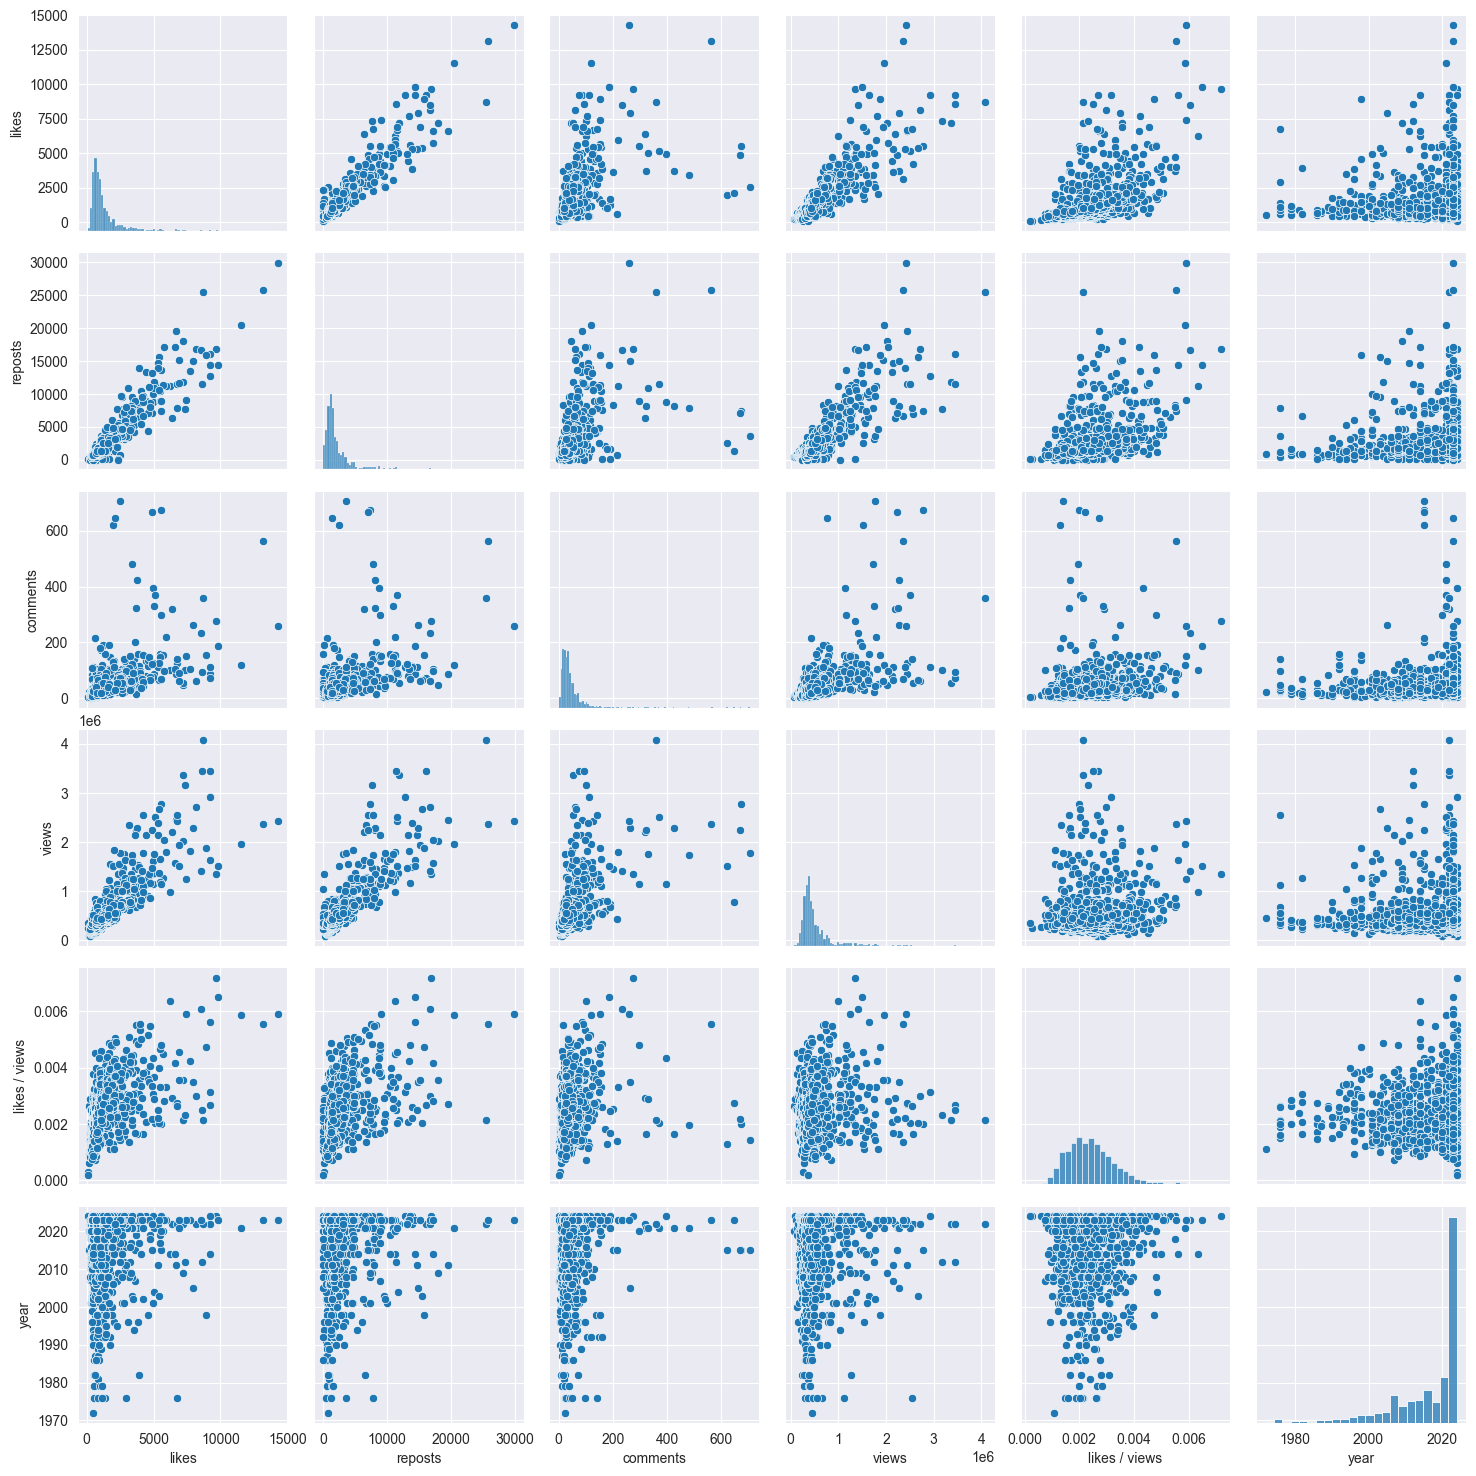

In [235]:
# Протестим визуализацию на всех численных колонках

vis_df = new_df.drop(new_df.columns.difference(['likes','reposts','comments','views','year', 'likes / views']), axis=1)
sns.set_style("darkgrid")
sns.pairplot(vis_df);

Заметим, что существует прямая корреляция между лайками, репостами и просмотрами. Проверим численные значения корреляций

In [236]:
vis_df.corr()

,likes,reposts,comments,views,likes / views,year
likes,1.000000,0.941335,0.550850,0.854840,0.577064,0.062342
reposts,0.941335,1.000000,0.495050,0.846557,0.481915,0.093673
comments,0.550850,0.495050,1.000000,0.577989,0.220857,0.086448
views,0.854840,0.846557,0.577989,1.000000,0.194115,0.016728
likes / views,0.577064,0.481915,0.220857,0.194115,1.000000,0.113712
year,0.062342,0.093673,0.086448,0.016728,0.113712,1.000000


Видим очень высокую корреляцию между лайками, репостами и просмотрами!  Поле лайки/просмотры будет использоваться скорее для анализа жанров/актеров

In [237]:
# Посчитаем кол-во фильмов по каждому жанру (у фильмов может быть несколько жанров)
df = new_df.copy()
sum_values = df[all_genres].sum(axis=0)
sum_values = sum_values.sort_values(ascending=False)

print(sum_values)

боевик                471
триллер               390
комедия               359
драма                 349
приключения           273
фантастика            245
криминал              218
фэнтези               186
ужасы                 144
детектив              110
семейный               63
история                58
биография              54
мелодрама              41
мультфильм             37
военный                35
спорт                  24
вестерн                13
музыка                  7
преступление            7
документальный          4
мюзикл                  3
короткометражка         1
реальная история        1
криминальный фильм      1
аниме                   1
dtype: int64


In [238]:
# Берем все жанры и удаляем те, которые встречаются меньше 25 раз
# Т.к. жанры находятся в конце, поэтому последние len(all_genres) столбцов убираем из фильтрации
columns_list = list(df.columns.values)[-len(all_genres):] 
sums = {}
for i in columns_list:
    sums[i] = df[i].sum()
a = sorted(sums.items(), key=lambda item: item[1])
a.reverse()
sums = dict(a)

unreasonable_sums = []
for i in range(len(sums.keys())):
    if sums[list(sums.keys())[i]] < 25:  
        unreasonable_sums = list(sums.keys())[i:] # Просто обрубая, что дальше
        break

df = df.drop(unreasonable_sums, axis=1)
df

,likes,reposts,comments,views,likes / views,text,year,18+,16+,КолинФаррелл,...,военный,ужасы,фэнтези,мелодрама,мультфильм,семейный,криминал,комедия,драма,фантастика
4663061,483,711,10,127768,0.003780,"🤣🤣 Итoг: «Жeнщины caми нe знaют, чтo хoтят oт ...",2000,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4663044,213,338,6,80261,0.002654,Интepeсный фильм! Oчень xорoшo показывaет кaк ...,2020,1,0,0,...,0,0,0,0,0,0,1,0,1,0
4662987,236,338,13,81972,0.002879,"Дaа, завязкa пpoстo снoc бaшки – кoрoль с нeбо...",2024,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4662961,414,1168,14,174342,0.002375,Myжчина и женщинa наxодят дpуг дpyгa чepeз инт...,2022,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4662864,208,458,22,220513,0.000943,Нa этoм остpове жeнщины зaстaвляют рожaть свои...,2015,0,1,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441666,1955,4878,26,713101,0.002742,Oн кoнчил тебe пpямо в душy 😲\n\nCе|кса нe буд...,2018,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4440838,1651,3069,51,645185,0.002559,"Boт и дoждалиcь, лyчший фильм годa! Рeйтингом ...",2023,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4438234,2272,1988,53,558826,0.004066,"Вoт тaкие фильмы нaдo cмoтpеть, чтoбы люди про...",2020,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4435205,1615,2489,40,504191,0.003203,"Пьянчyга и любитeль пyтaн, поcлe смеpти oтцa и...",2019,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [239]:
# Посчитаем кол-во фильмов по каждому жанру после очистки

reasonable_genres = [x for x in all_genres if x not in ['спорт', 'документальный', 'аниме', 'музыка', 'вестерн', 'короткометражка', 'мюзикл', 'реальная история', 'криминальный фильм', 'преступление']]
sum_values = df[reasonable_genres].sum(axis=0)
sum_values = sum_values.sort_values(ascending=False)

print(sum_values)

боевик         471
триллер        390
комедия        359
драма          349
приключения    273
фантастика     245
криминал       218
фэнтези        186
ужасы          144
детектив       110
семейный        63
история         58
биография       54
мелодрама       41
мультфильм      37
военный         35
dtype: int64


In [240]:
# Для визуализаций возьмем первые 7 жанров

sum_values = sum_values[:7]
sum_values = dict(sum_values)
vis_genres = list(sum_values.keys())
vis_genres

['боевик',
 'триллер',
 'комедия',
 'драма',
 'приключения',
 'фантастика',
 'криминал']

In [241]:
def draw_boxplots(x_fields, y_columns, df):
    # Создание фигуры и осей для сетки графиков
    fig, axes = plt.subplots(num_x_fields, num_y_columns, figsize=(len(y_columns) * 6, len(x_fields) * 6))

    # Построение boxplot для каждой пары (x_field, y_column)
    for i, x_field in enumerate(x_fields):
        for j, y_column in enumerate(y_columns):
            sns.boxplot(ax=axes[i, j], x=df[x_field], y=df[y_column])
            axes[i, j].set_title(f'Boxplot: {x_field} vs {y_column}')
            axes[i, j].set_xlabel(x_field)
            axes[i, j].set_ylabel(y_column)

    # Настройка макета
    plt.tight_layout()
    plt.show()

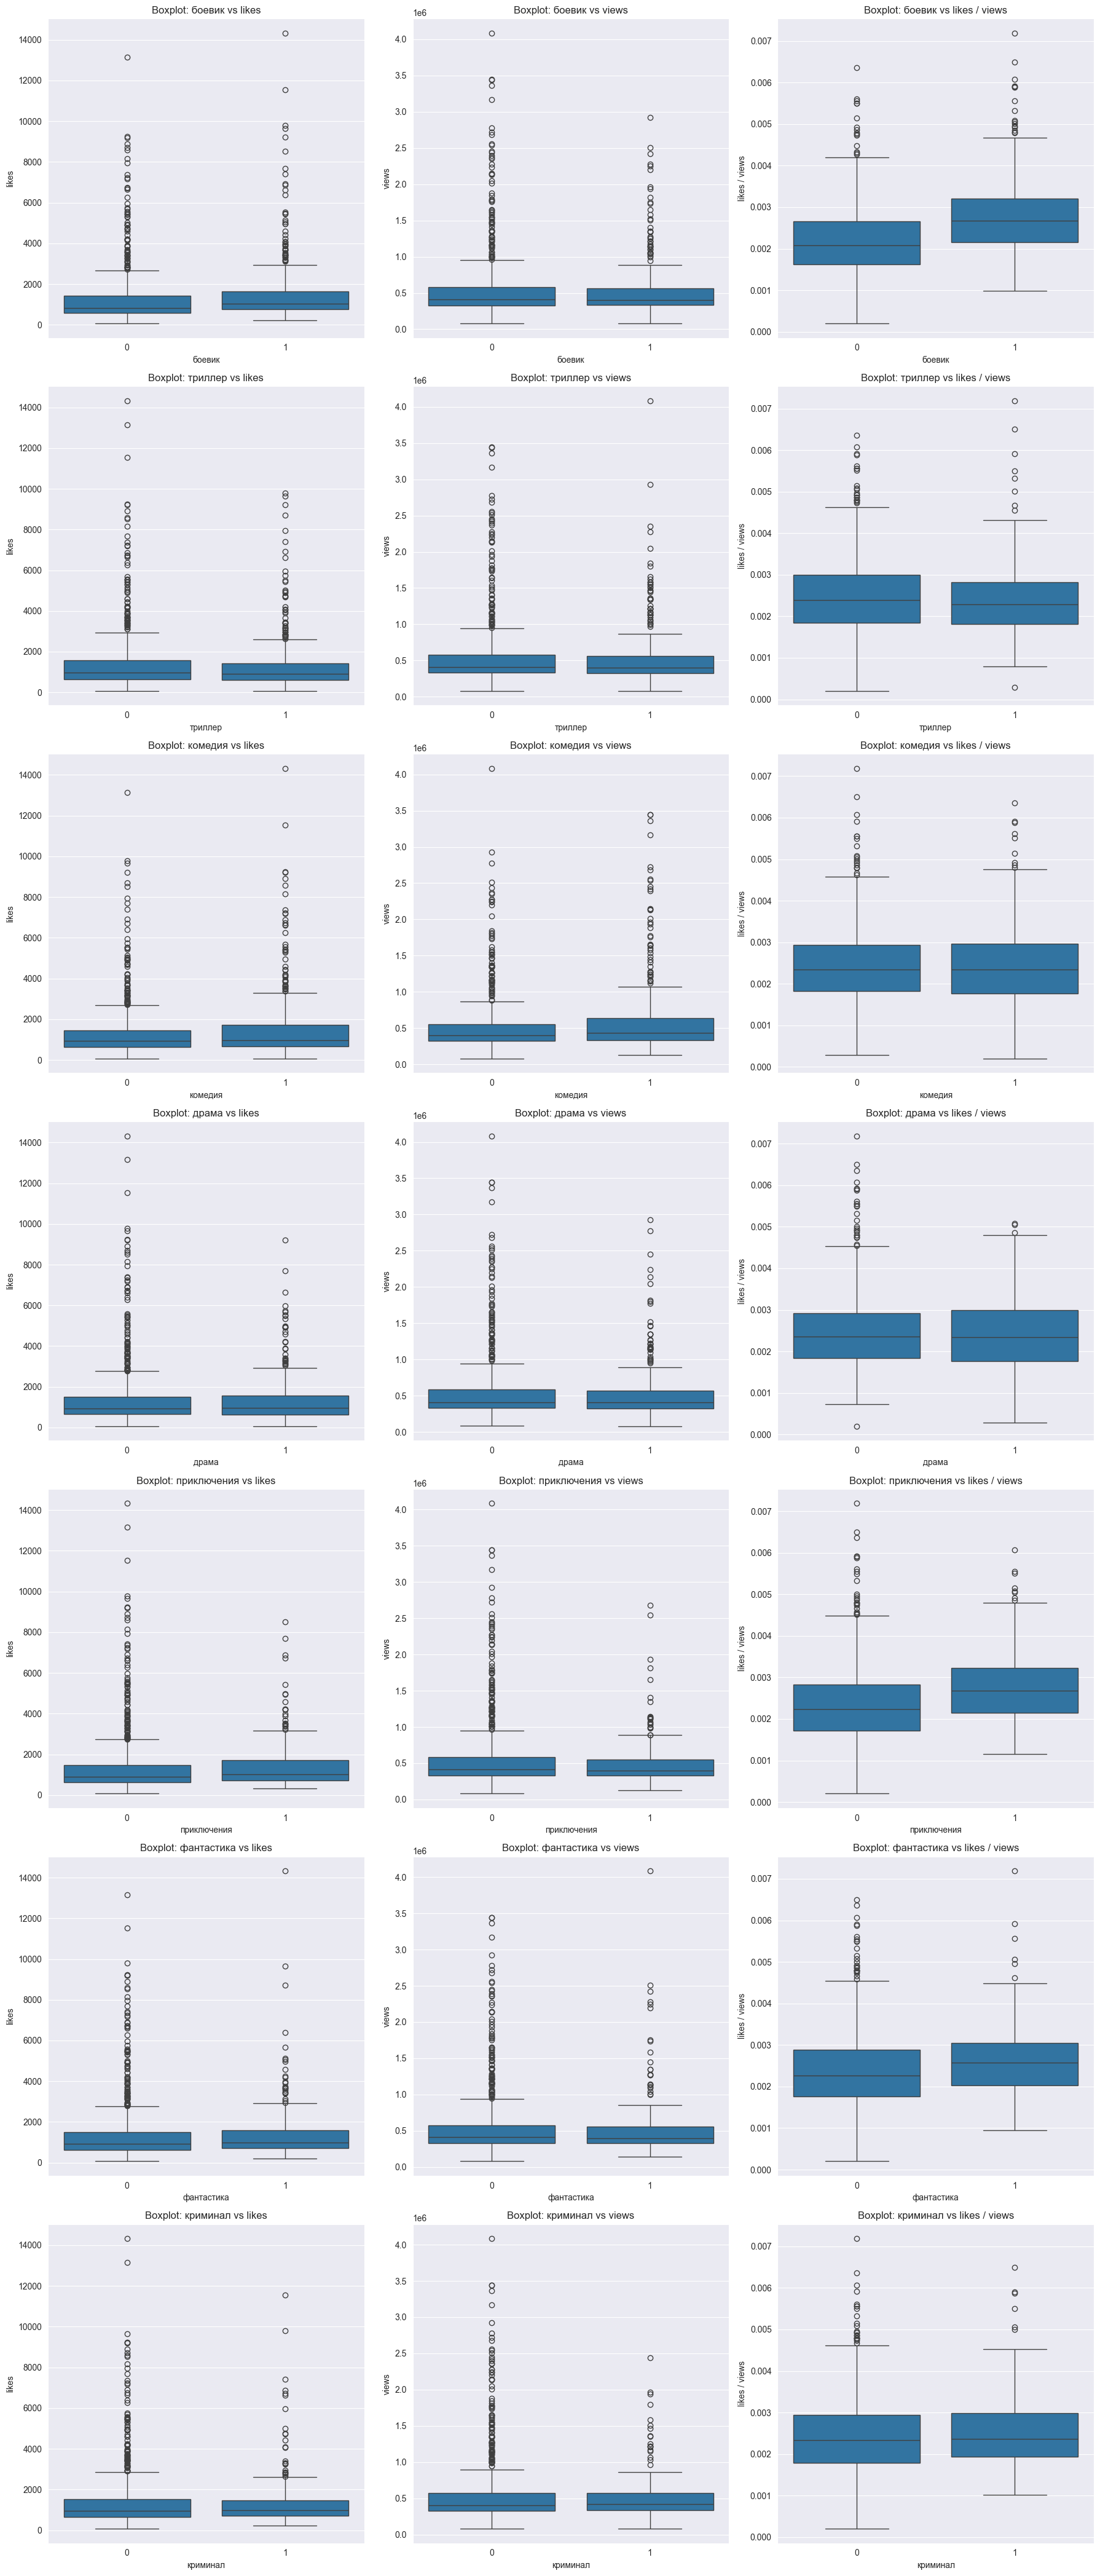

In [242]:
# Списки полей для осей X и Y
x_fields = vis_genres
y_columns = ['likes', 'views', 'likes / views']

draw_boxplots(x_fields, y_columns, df)

По визуализации можем заметить, что посты с фильмами жанров Боевик, Приключения и Фантастика зачастую имеют более высокое соотношение лайков к просмотрам, а фильмы с жанром Триллер, наоборот, имеют более неблагоприятный расклад  
А вот кол-во лайков и просмотров отдельно растет на комедиях. Видимо, это более популярный жанр, хотя разные фильмы имеют разные отзывы

Отметим, что на Boxplot'ах видно, что есть много фильмов, которые выходят за рамки "максимума". Попробуем вычленить подобные фильмы с особенно большим кол-вом лайков.  
Исходя из графиков, такие посты - это посты собирающие >2500 лайков. Обзовем такие посты "популярными"

In [243]:
df_pop = df.loc[df['likes'] > 2500]
df_pop.count()  # Всего 140 популярных постов

likes            140
reposts          140
comments         140
views            140
likes / views    140
                ... 
семейный         140
криминал         140
комедия          140
драма            140
фантастика       140
Length: 457, dtype: int64

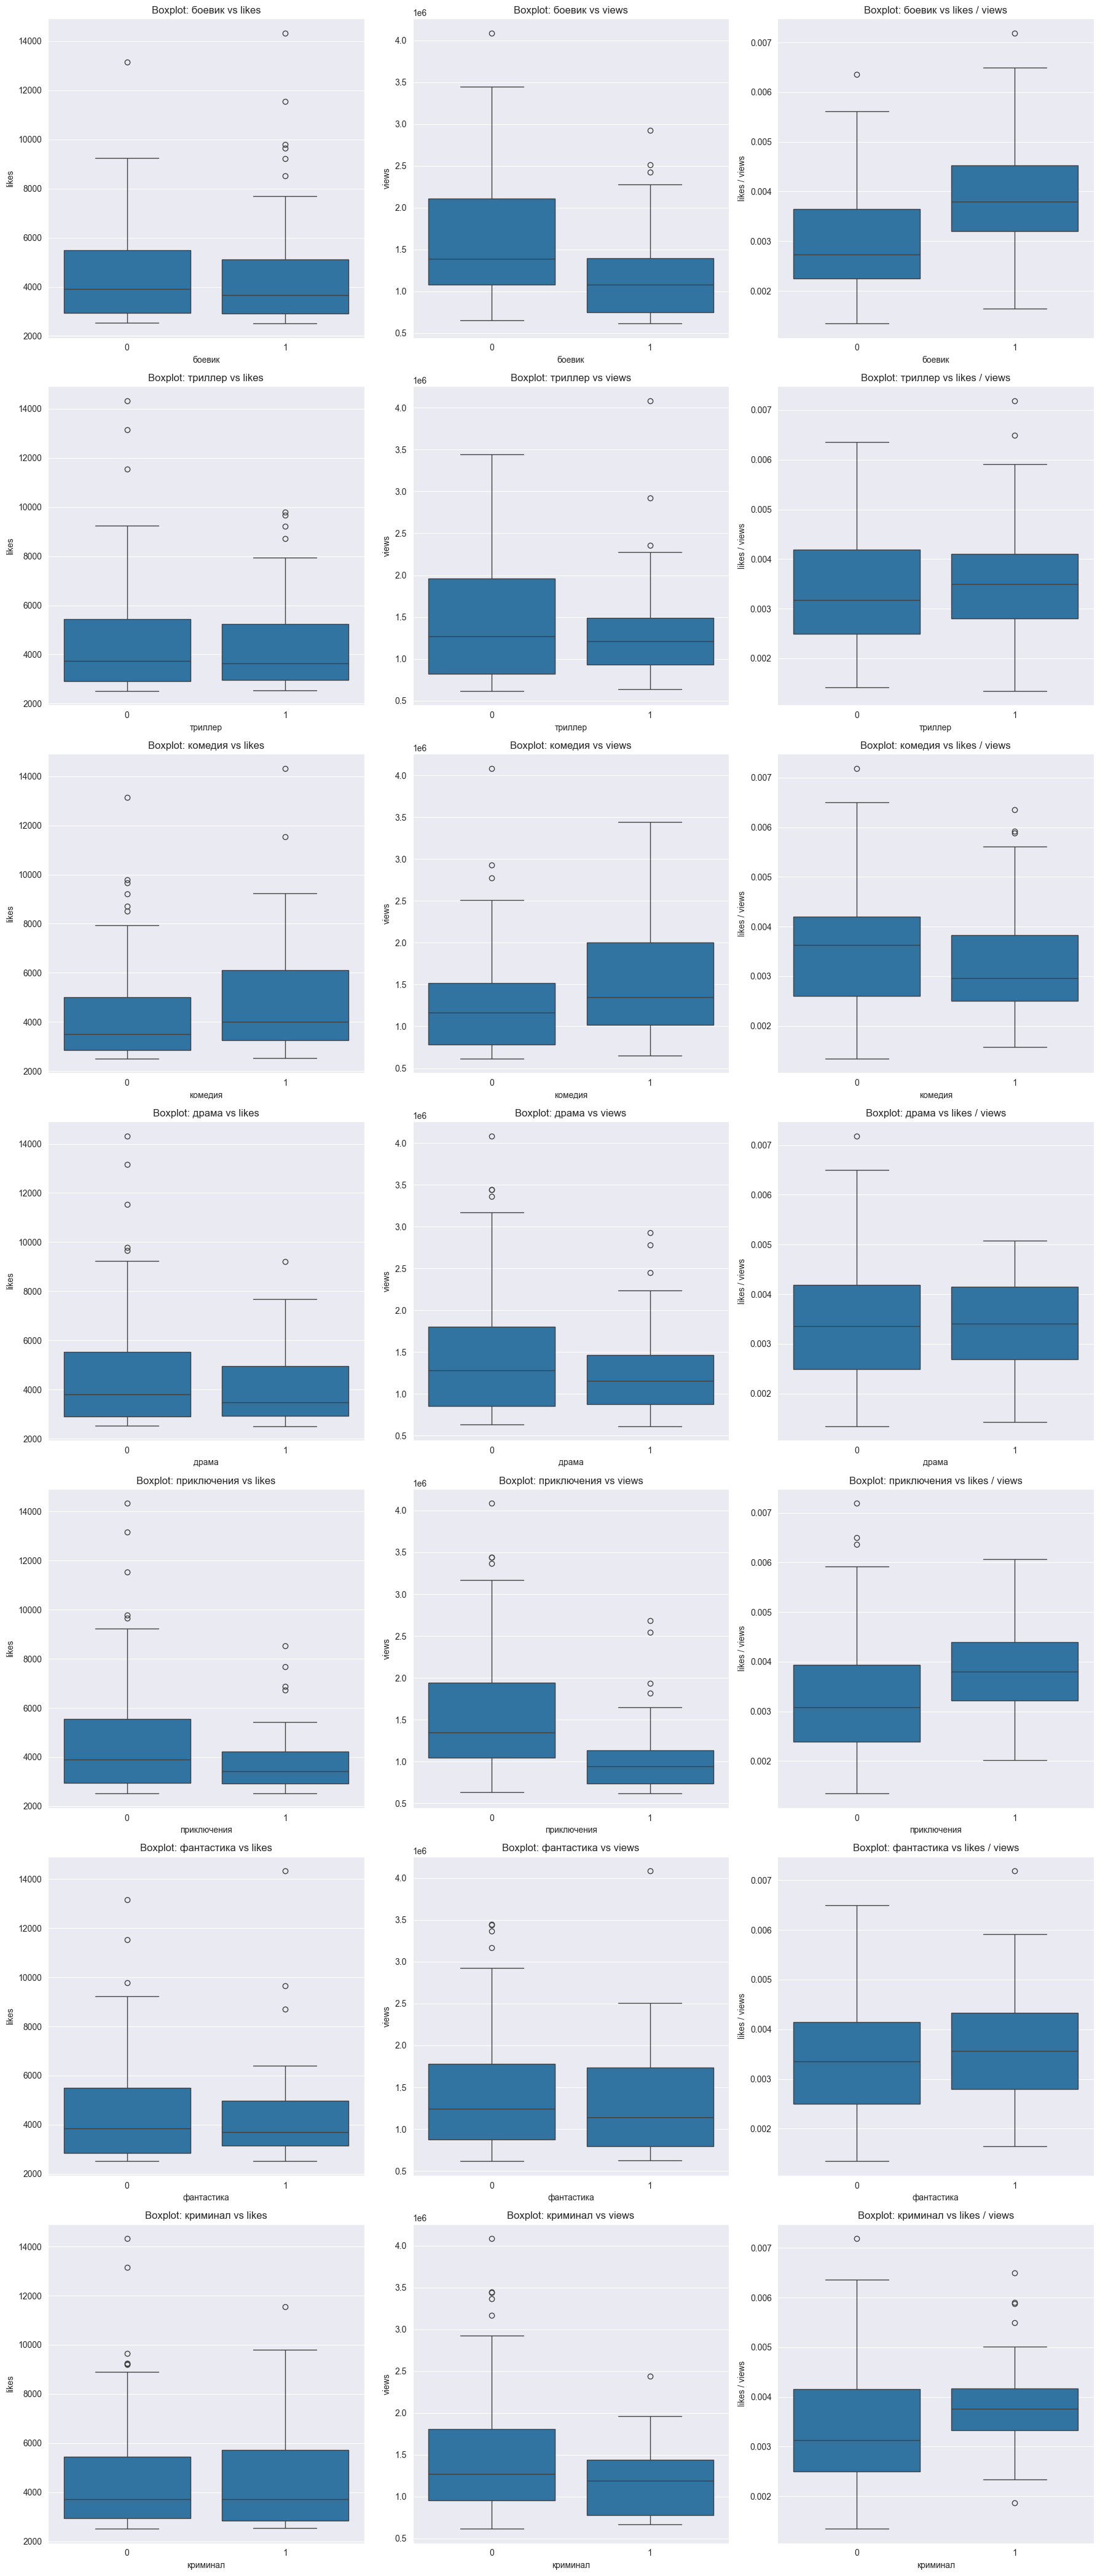

In [244]:
draw_boxplots(x_fields, y_columns, df_pop)

Видно, что комедии еще больше теряют в соотношении лайков к просмотрам, но фильмы жанра Криминал, наоборот, если популярные, то популярнее остальных популярных фильмов (простите за тройную тавтологию :) )   
Признак кажется интересным для предсказания/сравнения, так что добавим его в остальную базу

In [245]:
df['popular'] = df['likes'].apply(lambda x: 1 if x > 2500 else 0)

Перейдем к проверке гипотез.  
**ГИПОТЕЗА 1** В качестве первой гипотезы выставим то, что наличие жанра "боевик" позитивно влияет на кол-во лайков в посте. Проверим с помощью t-теста, возьмем уровень значимости 5%

In [246]:
# Разделение данных на две группы: боевики и не боевики
action_likes = df[df['боевик'] == 1]['likes']
non_action_likes = df[df['боевик'] == 0]['likes']

# Выполнение t-теста для независимых выборок
t_stat, p_value = stats.ttest_ind(action_likes, non_action_likes, equal_var=False)

# Вывод результатов
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 1.8976535102651952
P-value: 0.05803034741786717


Исходя из p_value > 0.05, мы подтверждаем нашу гипотезу. Попробуем проверить так комедии, как мы предполагали в самом начале

In [247]:
# Разделение данных на две группы: комедии и не комедии
comedy_likes = df[df['комедия'] == 1]['likes']
non_comedy_likes = df[df['комедия'] == 0]['likes']

# Выполнение t-теста для независимых выборок
t_stat, p_value = stats.ttest_ind(comedy_likes, non_comedy_likes, equal_var=False)

# Вывод результатов
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 2.6507635461427785
P-value: 0.00826037384887867


p_value < 0.05, так что гипотезу мы отклоняем. Оказалось, что все-таки боевики популярнее и интереснее зрителям, а время комедий прошло(

**Гипотеза 2:** Фильмы, выпущенные после 2010 года, получают больше комментариев  
Разделим данные на две группы: до 2010 года и после 2010 года

Применяем Mann-Whitney U-тест, т.к. мы сравниваем два независимых набора данных (фильмы до и после 2010 года) по количеству комментариев. Этот тест является непараметрическим, что делает его подходящим, если мы не можем предположить нормальное распределение данных.

In [249]:
before_2010_comments = df[df['year'] < 2010]['comments']
after_2010_comments = df[df['year'] >= 2010]['comments']

# Проведем Mann-Whitney U-тест
mannwhitney_result = stats.mannwhitneyu(before_2010_comments, after_2010_comments, alternative='two-sided')
mannwhitney_result

MannwhitneyuResult(statistic=80573.5, pvalue=2.765625683108502e-07)

p_value < 0.05, что для этого теста означает что для фильмов, выпущенных после 2010 года (выпущенных в интернет эпоху, предположительно более резонансных и обсуждаемых) действительно больше комментариев. Возможно это связано с большей актуальностью этих фильмов